# Homework 2: Tagging and Parsing

Student Name: Alex Cheadle

Student ID: 847388

Python version used: 2.7

## General info

<b>Due date</b>: 5pm, Thursday March 30

<b>Submission method</b>: see LMS

<b>Submission materials</b>: completed copy of this iPython notebook

<b>Late submissions</b>: -20% per day

<b>Marks</b>: 5% of mark for class

<b>Overview</b>: In this homework, you'll be building a hidden Markov (HMM) part-of-speech tagger and applying it to text. This includes training over labelled text, then prediction (decoding) to tag an unlabelled sentence and evaluating the result. The catch is that you're to do so using algorithms from probabilistic parsing. The HMM is a kind of weighted state-machine, which formally defines a (probablistic) regular language. Context free languages subsume the regular languages, and therefore a HMM is a specific type of PCFG. Your task will be to use this equivalence in order to implement HMM decoding using PCFG parsing routings, and use this for part-of-speech tagging. 

<b>Materials</b>: See the main class LMS page for information on the basic setup required for this class, including an iPython notebook viewer and the python packages NLTK, Numpy, Scipy, Matplotlib, Scikit-Learn, and Gemsim. In particular, if you are not using a lab computer which already has it installed, we recommend installing all the data for NLTK, since you will need various parts of it to complete this assignment. You can also use any Python built-in packages, but do not use any other 3rd party packages; if your iPython notebook doesn't run on the marker's machine, you will lose marks.  

<b>Evaluation</b>: Your iPython notebook should run end-to-end without any errors in a reasonable amount of time, and you must follow all instructions provided below, including specific implementation requirements and instructions for what needs to be printed (please avoid printing output we don't ask for). The amount each section is worth is given in parenthesis after the instructions. You will be marked not only on the correctness of your methods, but also the quality and efficency of your code: in particular, you should be careful to use Python built-in functions and operators when appropriate and pick descriptive variable names that adhere to <a href="https://www.python.org/dev/peps/pep-0008/">Python style requirements</a>. If you think it might be unclear what you are doing, you should comment your code to help the marker make sense of it.

<b>Extra credit</b>: Each homework has a task which is optional with respect to getting full marks on the assignment, but that can be used to offset any points lost on this or any other homework assignment (but not the final project or the exam). We recommend you skip over this step on your first pass, and come back if you have time: the amount of effort required to receive full marks (1 point) on an extra credit question will be substantially more than earning the same amount of credit on other parts of the homework.

<b>Updates</b>: Any major changes to the assignment will be announced via LMS. Minor changes and clarifications will be announced in the forum on LMS, we recommend you check the forum regularly.

<b>Academic Misconduct</b>: For most people, collaboration will form a natural part of the undertaking of this homework, and we encourge you to discuss it in general terms with other students. However, this ultimately is still an individual task, and so reuse of code or other instances of clear influence will be considered cheating. We will be checking submissions for originality and will invoke the University’s <a href="http://academichonesty.unimelb.edu.au/policy.html">Academic Misconduct policy</a> where inappropriate levels of collusion or plagiarism are deemed to have taken place.


## HMM Tagging

<b>Instructions</b>: For this homework we will be using the tagged sentences in the `nltk.corpus.treebank` corpus. You should start by accessing this dataset, using the `tagged_sents` method to access the sentences in the corpus, which are composed of pairs of tokens and their part of speech tags. For this homework, use all the `fileids` for training (we won't both with heldout validation or testing sets for the homework.) For each sentence, add special tokens, `<s>` and `</s>`, to the start and end. You should lower-case the tokens in the text, to limit the number of parameters in the model and allow for better generalisation.

Estimate the parameters of a _first order_ HMM tagger over the training partition. First order means that the transition probabilities depend on one previous tag, i.e., the A matrix stores $p(t | t')$ entries, where _t_ and _t'_ are the current and previous tag, respectively. Estimating the parameters (a.k.a. training) means learning the transition (A), observation (O) and starting state (pi) parameter. You will need to compute normalised frequency counts, as described in the lecture (and also the workshop and reading). You may want to store these using special dictionary variants from `collections`, such as `Counter` or `defaultdict`, or use `numpy.array` objects. Don't worry about smoothing the parameters for this homework. 

You should include in your transition parameters the transition to the `</s>` token, which ends the sequence. You may want to do the same for the `<s>` token, in which case the pi vector can be treated as a special row in A.

Your code should print out the following summary numbers: 1) the number of tag types, 2) the number of word tokens and word types (unique words), and 4) the number of parameters in each of A, O, and pi.

(1.5 marks)

In [1]:
from nltk.corpus import treebank
taggedSents = treebank.tagged_sents()
cleanedSents = []


for sent in taggedSents :
    newSent = []
    newSent.append(('<s>', 'START'))
    for (word, tag) in sent:
        newSent.append((word.lower(), tag))
    newSent.append(('</s>', 'END'))
    cleanedSents.append(newSent)
cleanedSents[0]
len(cleanedSents)

3914

In [2]:
print cleanedSents[0]

[('<s>', 'START'), (u'pierre', u'NNP'), (u'vinken', u'NNP'), (u',', u','), (u'61', u'CD'), (u'years', u'NNS'), (u'old', u'JJ'), (u',', u','), (u'will', u'MD'), (u'join', u'VB'), (u'the', u'DT'), (u'board', u'NN'), (u'as', u'IN'), (u'a', u'DT'), (u'nonexecutive', u'JJ'), (u'director', u'NN'), (u'nov.', u'NNP'), (u'29', u'CD'), (u'.', u'.'), ('</s>', 'END')]


In [28]:
from collections import Counter, defaultdict
# Need to make pi (prob that each tag! starts the chain)
# A matrix num Tags * num Tags.
# which A(t1, t2) is P(t1 | t2)
# O matrix num tags * num words
# O(t1, w1) = P(t1 == w1)

# Calc pi
firstTags = [sent[1][1] for sent in cleanedSents]
counter = Counter()
for firstTag in firstTags :
    counter[firstTag] += 1
    
#posTags = list(counter)
numberOfTags = sum(counter.values()) 

pi = defaultdict()
for tag in counter: 
    pi[tag] = float(counter[tag]) / float(numberOfTags)

# Now lets calc A
tagPairCounter = Counter()
for sent in cleanedSents:
    for i in range (0, len(sent) - 1):
        firstTag = sent[i][1]
        secondTag = sent[i+1][1]
        tagPairCounter[(firstTag, secondTag)] += 1


# P(t2 | t1) = N(t1, t2) / N(t1, *)
# where t2 is the new tag (RHS)

# totalDict is a dict such that totalDict[t2] = N(t2, *)
tagFreq = Counter()
for (t1, t2) in tagPairCounter :
    freq = tagPairCounter[(t1, t2)]
    tagFreq[t1] += freq
    
A = defaultdict()
for (t1, t2) in tagPairCounter :
    freq = tagPairCounter[(t1, t2)]
    A[(t1, t2)] = float(freq) / float(tagFreq[t1])
    
# Now, lets calc O
# O matrix num tags * num words
# O(t1, w1) = P(w1 is of tag t1) = num(w1 tagged as t1) / num(t1)

allWordWithTag = Counter()
wordFreqs = Counter()
for sent in cleanedSents:
    for (word, tag) in sent:
        allWordWithTag[(word, tag)] += 1
        wordFreqs[word] += 1

# So allWordWithTag has all word Tag pairs, without duplicates
O = defaultdict()
for (word, tag) in allWordWithTag :
    O[word, tag] = float(allWordWithTag[(word, tag)]) / float (wordFreqs[(word)])

    
# NUmber of word tokens
numWordTokens = 0
for sent in cleanedSents:
    for (word, tag) in sent:
        numWordTokens += 1

print ("The number of tag types: " + str(len(tagFreq)) + " including START, but not END")
print ("The number of word tokens " + str(numWordTokens))
print ("The number of unique words " + str(len(wordFreqs)))
print ("A has " + str(len(A)) + " params")
print ("O has " + str(len(O)) + " params")
print ("pi has " + str(len(pi)) + " params")


The number of tag types: 47
The number of word tokens 108504
The number of unique words 11389
A has 1047 params
O has 13155 params
pi has 36 params


In [64]:
print(tagFreq)

Counter({u'NN': 13166, u'IN': 9857, u'NNP': 9410, u'DT': 8165, u'-NONE-': 6592, u'NNS': 6047, u'JJ': 5834, u',': 4886, 'START': 3914, u'.': 3874, u'CD': 3546, u'VBD': 3043, u'RB': 2822, u'VB': 2554, u'CC': 2265, u'TO': 2179, u'VBN': 2134, u'VBZ': 2125, u'PRP': 1716, u'VBG': 1460, u'VBP': 1321, u'MD': 927, u'POS': 824, u'PRP$': 766, u'$': 724, u'``': 712, u"''": 694, u':': 563, u'WDT': 445, u'JJR': 381, u'NNPS': 244, u'WP': 241, u'RP': 216, u'JJS': 182, u'WRB': 178, u'RBR': 136, u'-RRB-': 126, u'-LRB-': 120, u'EX': 88, u'RBS': 35, u'PDT': 27, u'#': 16, u'WP$': 14, u'LS': 13, u'FW': 4, u'UH': 3, u'SYM': 1})


In [4]:
print(pi)
print(numberOfTags)
print(len(cleanedSents))

defaultdict(None, {u'PRP$': 0.00740929994890138, u'VBG': 0.004343382728666326, u'VBD': 0.0002554931016862545, u'VBN': 0.0017884517118037812, u"''": 0.0002554931016862545, u'WDT': 0.000510986203372509, u'JJ': 0.036535513541134386, u'WP': 0.0035769034236075624, u'VBZ': 0.0022994379151762903, u'DT': 0.2312212570260603, u'$': 0.0012774655084312723, u'NN': 0.04445579969340828, u'TO': 0.0012774655084312723, u'PRP': 0.06259580991313235, u'RB': 0.04471129279509453, u'-LRB-': 0.0017884517118037812, u':': 0.002810424118548799, u'NNS': 0.04675523760858457, u'NNP': 0.19775166070516095, u'``': 0.07562595809913132, u'WRB': 0.006387327542156361, u'CC': 0.05135411343893715, u'LS': 0.0017884517118037812, u'PDT': 0.0007664793050587634, u'RBS': 0.000510986203372509, u'RBR': 0.0007664793050587634, u'CD': 0.008431272355646398, u'-NONE-': 0.020950434338272865, u'EX': 0.004343382728666326, u'IN': 0.1290240163515585, u'MD': 0.0002554931016862545, u'NNPS': 0.0025549310168625446, u'JJS': 0.0015329586101175269, 

<b>Instructions</b>: The next part requires thinking about the relationships between formal languages. Recall that the regular languages (including the HMM) are a subset of the context-free languages (PCFGs). Note that although we have _weighted (probabilistic)_ grammars, the same relation still holds. Your challenge is to figure out a _context-free grammar_ that corresponds to the HMM tagger, and the weighting of each production. 

To help get started, consider a part-of-speech tagged sentence, e.g., _`<s>` Donald/NNP has/VBZ small/JJ hands/NNS_ `</s>`.  The sequence of tags forms a chain, which is already a type of tree. Think about how this tagged sequence is scored by the HMM to compute the joint probability, which might help to figure out what non-terminal symbols you might need and where to attach a special _S_ start symbol.   

Use the HMM parameters computed above to construct a PCFG, using the `nltk.grammar.ProbabilisticProduction` and `nltk.grammar.PCFG` classes. This will require you to come up with a 'grammar' representation of the HMM, which you should create directly from your HMM parameters including the HMM probabilities in the PCFG productions. Your grammar should be in Chomsky Normal Form.

Finally, implement a probabilistic CYK parser using your tagging _PCFG_. Feel free to cut-and-paste code from the supplied notebooks, although ensure when you do this you clearly specify in comments the source of the code (and if you make changes to the copied code, then use comments to flag these changes.) Apply this "tagger" to the test sentence 

    <s> a dozen dinosaurs debate deals for daily dessert delivery . </s>

and print the predicted tree and the sequence of POS tags. During code development you may want to also view the chart.

*Note: Depending on how you go about this, you may need to relax the test for grammar validity in the `PCFG` constructor by changing the constant `nltk.grammar.PCFG.EPSILON`.* 

(2.5 marks)

In [134]:
from nltk.grammar import ProbabilisticProduction, PCFG, Nonterminal
# First we need the non terminal to terminal productions 
# ie what is stored in O
productions = []
    
for (word, tag) in O:
    if word != '<s>' :
        theProb = O[(word, tag)]
        adjustedProb = theProb / 10000000000
        productions.append(ProbabilisticProduction(Nonterminal(tag), [word], prob = adjustedProb))
   

In [135]:
# Now, we can deal with transitions between states (tags)
    
for (tag1, tag2) in A:
    theProb = A[(tag1, tag2)]
    if (tag2 == 'END') :
        productions.append(ProbabilisticProduction(Nonterminal(tag1), [Nonterminal(tag2)], prob = theProb))
    else :
        productions.append(ProbabilisticProduction(Nonterminal(tag1), [Nonterminal(tag2),Nonterminal(tag2)], prob = theProb))

In [136]:
#We don't actually need to use pi, as it's included as a row of A
# But we do need the start production! 
productions.append(ProbabilisticProduction(Nonterminal('START'),[Nonterminal('START'),Nonterminal('START')], prob = 0.000000001))
productions.append(ProbabilisticProduction(Nonterminal('START'),['<s>'], prob = 1))
productions.append(ProbabilisticProduction(Nonterminal('END'),['</s>'], prob = 0.00000000001))




In [137]:
PCFG.EPSILON = 1000000
pcfg = PCFG(Nonterminal("START"),productions)

print pcfg.is_flexible_chomsky_normal_form()

True


,a,dozen,dinosaurs,
"[0,1]START [1.00000]","[0,2]","[0,3]START [0.00000] (k=1, START -> START START [1e-05])","[0,4]START [0.00000] (k=1, START -> START START [1e-05])","[0,5]START [0.00000] (k=1, START -> START START [1e-05])"
,"[1,2]NN [0.00000]LS [0.00000]JJ [0.00000]IN [0.00000]DT [0.00000]NNP [0.00000]","[1,3]PRP$ [0.00000] (k=2, PRP$ -> NN NN [0.439948])VBG [0.00000] (k=2, VBG -> NN NN [0.146575])VBD [0.00000] (k=2, VBD -> NN NN [0.0295761])`` [0.00000] (k=2, `` -> NN NN [0.0983146])VBN [0.00000] (k=2, VBN -> NN NN [0.0674789]), [0.00000] (k=2, , -> NN NN [0.0485059])'' [0.00000] (k=2, '' -> NN NN [0.0403458])VBP [0.00000] (k=2, VBP -> NN NN [0.0264951])WDT [0.00000] (k=2, WDT -> NN NN [0.00674157])JJ [0.00000] (k=2, JJ -> NN NN [0.447549])WP [0.00000] (k=2, WP -> NN NN [0.0124481])VBZ [0.00000] (k=2, VBZ -> NN NN [0.0390588])DT [0.00000] (k=2, DT -> NN NN [0.47079])RP [0.00000] (k=2, RP -> NN NN [0.0509259])NN [0.00000] (k=2, NN -> NN NN [0.125854])FW [0.00000] (k=2, FW -> NN NN [0.25])POS [0.00000] (k=2, POS -> NN NN [0.412621]). [0.00000] (k=2, . -> NN NN [0.000258131])TO [0.00000] (k=2, TO -> NN NN [0.0279945])PRP [0.00000] (k=2, PRP -> NN NN [0.0034965])RB [0.00000] (k=2, RB -> NN NN [0.0145287])-LRB- [0.00000] (k=2, -LRB- -> NN NN [0.05]): [0.00000] (k=2, : -> NN NN [0.035524])NNS [0.00000] (k=2, NNS -> NN NN [0.0224905])NNP [0.00000] (k=2, NNP -> NN NN [0.0553666])VB [0.00000] (k=2, VB -> NN NN [0.0665623])WRB [0.00000] (k=2, WRB -> NN NN [0.0617978])CC [0.00000] (k=2, CC -> NN NN [0.12053])CD [0.00000] (k=2, CD -> NN NN [0.193739])START [0.00000] (k=2, START -> NN NN [0.0444558])-NONE- [0.00000] (k=2, -NONE- -> NN NN [0.0189624])IN [0.00000] (k=2, IN -> NN NN [0.109567])WP$ [0.00000] (k=2, WP$ -> NN NN [0.571429])NNPS [0.00000] (k=2, NNPS -> NN NN [0.0204918])-RRB- [0.00000] (k=2, -RRB- -> NN NN [0.0396825])JJS [0.00000] (k=2, JJS -> NN NN [0.28022])JJR [0.00000] (k=2, JJR -> NN NN [0.2021])","[1,4]PRP$ [0.00000] (k=3, PRP$ -> NNS NNS [0.206266])VBG [0.00000] (k=3, VBG -> NNS NNS [0.0945205])VBD [0.00000] (k=3, VBD -> NNS NNS [0.0193888])`` [0.00000] (k=3, `` -> NNS NNS [0.0308989])VBN [0.00000] (k=3, VBN -> NNS NNS [0.0360825]), [0.00000] (k=3, , -> NNS NNS [0.026402])'' [0.00000] (k=3, '' -> NNS NNS [0.0201729])VBP [0.00000] (k=3, VBP -> NNS NNS [0.0219531])WDT [0.00000] (k=3, WDT -> NNS NNS [0.0157303])JJ [0.00000] (k=3, JJ -> NNS NNS [0.243744])WP [0.00000] (k=3, WP -> NNS NNS [0.00829876])VBZ [0.00000] (k=3, VBZ -> NNS NNS [0.0122353])DT [0.00000] (k=3, DT -> NNS NNS [0.0774036])RP [0.00000] (k=3, RP -> NNS NNS [0.0555556])NN [0.00000] (k=3, NN -> NNS NNS [0.0817257])POS [0.00000] (k=3, POS -> NNS NNS [0.127427])TO [0.00000] (k=3, TO -> NNS NNS [0.0289123])PRP [0.00000] (k=3, PRP -> NNS NNS [0.0011655])RB [0.00000] (k=3, RB -> NNS NNS [0.00460666])-LRB- [0.00000] (k=3, -LRB- -> NNS NNS [0.025]): [0.00000] (k=3, : -> NNS NNS [0.0301954])NNS [0.00000] (k=3, NNS -> NNS NNS [0.0125682])NNP [0.00000] (k=3, NNP -> NNS NNS [0.0226355])VB [0.00000] (k=3, VB -> NNS NNS [0.0446359])WRB [0.00000] (k=3, WRB -> NNS NNS [0.0674157])CC [0.00000] (k=3, CC -> NNS NNS [0.0701987])CD [0.00000] (k=3, CD -> NNS NNS [0.14749])START [0.00000] (k=3, START -> NNS NNS [0.0467552])-NONE- [0.00000] (k=3, -NONE- -> NNS NNS [0.00530947])IN [0.00000] (k=3, IN -> NNS NNS [0.0620879])WP$ [0.00000] (k=3, WP$ -> NNS NNS [0.357143])MD [0.00000] (k=3, MD -> NNS NNS [0.00107875])NNPS [0.00000] (k=3, NNPS -> NNS NNS [0.00819672])JJS [0.00000] (k=3, JJS -> NNS NNS [0.175824])JJR [0.00000] (k=3, JJR -> NNS NNS [0.194226])","[1,5]PRP$ [0.00000] (k=3, PRP$ -> JJ JJ [0.223238])VBG [0.00000] (k=2, VBG -> DT DT [0.182877])VBD [0.00000] (k=2, VBD -> DT DT [0.127834])`` [0.00000] (k=2, `` -> DT DT [0.176966])VBN [0.00000] (k=2, VBN -> DT DT [0.0529522]), [0.00000] (k=2, , -> DT DT [0.13508])'' [0.00000] (k=2, '' -> DT DT [0.0461095])VBP [0.00000] (k=2, VBP -> DT DT [0.107494])WDT [0.00000] (k=2, WDT -> DT DT [0.0224719])JJ [0.00000] (k=2, JJ -> DT DT [0.0

Do it


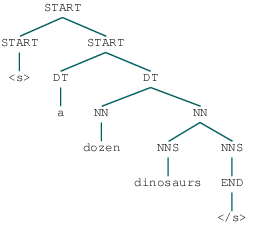

In [236]:
parse_CYK('<s> a dozen dinosaurs </s>'.split(), pcfg)
#parse_CYK('<s> a </s>'.split(), pcfg)

In [186]:
## Taken from WSTA_N6_probabilistic_parsing
import nltk
import nltk.grammar
from collections import defaultdict
from IPython.core.display import display, HTML

def parse_CYK(words, grammar):
    table = defaultdict(dict)    
    back = defaultdict(dict)
    
    # righter-most index j
    for j in range(1, len(words)+1):
        # insert token preterminal rewrites, POS -> 'word'
        token = words[j-1]
        for prod in grammar.productions(rhs=token):
            if len(prod.rhs()) == 1:
                table[j-1,j][prod.lhs()] = prod.prob()

        # deal with pesky unary productions 
        changes = True
        cell = table[j-1,j]
        while changes:
            # repeat this loop until no rule changes; will infinitely
            # loop for grammars with a unary cycle
            changes = False
            for non_term in list(cell.keys()):
                prob = cell[non_term]
                for prod in grammar.productions(rhs=non_term):
                    if len(prod.rhs()) == 1:
                        unary_prob = prod.prob() * prob
                        if unary_prob > cell.get(prod.lhs(), 0):
                            cell[prod.lhs()] = unary_prob
                            back[j-1,j][prod.lhs()] = (None, prod)
                            changes = True
        
        # now look for larger productions that span [i, j]
        # allowing i to move leftward over the input
        for i in range(j-2, -1, -1):
            cell = table[i,j]
            # k is the split point, i < k < j
            for k in range(i+1, j):
                # find chart cells based on the split point
                left_cell = table[i,k]
                right_cell = table[k,j]
                # find binary productions which handle a valid symbol A from left cell, X -> A B
                for left_nt, left_prob in left_cell.items():
                    for prod in grammar.productions(rhs=left_nt):
                        if len(prod.rhs()) == 2:
                            # check if the left and right cells have a valid parse
                            right_prob = right_cell.get(prod.rhs()[1])
                            if left_prob != None and right_prob != None:
                                # score the partial parse
                                prob = prod.prob() * left_prob * right_prob
                                if prob > cell.get(prod.lhs(), 0.0):
                                    # if it exceeds the current best analysis, update the cell
                                    cell[prod.lhs()] = prob
                                    # and store a record of how we got here
                                    back[i,j][prod.lhs()] = (k, prod)
    
    # display the table and back pointers
    display_CYK_chart(words, table, back)
    #I added the line below, and commented out the one above
    print_sequence(words, table, back)
    # have to build the tree from the back pointers
    return build_tree(words, back, grammar.start(), i=0, j=len(words))

def build_tree(words, back, symbol, i, j):
    backpointer = back[i, j].get(symbol)
    if backpointer == None:
        # X -> 'word' production
        assert j == i+1
        return nltk.tree.Tree(symbol, [words[i]])
    else:
        k, prod = back[i, j][symbol]
        if k != None:
            # X -> A B binary production
            left_subtree = build_tree(words, back, prod.rhs()[0], i=i, j=k)
            right_subtree = build_tree(words, back, prod.rhs()[1], i=k, j=j)
            return nltk.tree.Tree(symbol, [left_subtree, right_subtree])
        else:
            # X -> A unary production
            subtree = build_tree(words, back, prod.rhs()[0], i=i, j=j)
            return nltk.tree.Tree(symbol, [subtree])
        
# From here onwards is my own code, to interact with the above to give the 

def print_sequence(words, table, back):
    print("Do it")
    #print back

**Instructions:** This approach is pretty slow, which you may notice if you apply your method to much longer senentences. Clearly the CYK algorithm is too general, and thus is not optimised for tagging grammars. Your job is to tailor the CYK algorithm to speed up its tagging performance. Start by pasting in a copy of the PCYK function from the notebook, and then make your edits. Please ensure that you clearly mark the parts you have changed with comments. You are free to sacrifice generality of the algorithm, so that it only works for your style of grammar. Are there aspects of your grammar that can be exploited by small changes to the parsing code? Looking carefully at the parse chart might help you to identify these opporunities. 

Print out the time of running the original CYK parsing for an example sentence, and the time for your improved method (you may want to use the `timeit` library.) Also print the tag predictions for both parsing methods, to verify that they produce the same results.

(1 mark)

In [249]:
parse_CYK_improved('<s> a dozen dinosaurs </s>'.split(), pcfg)
#parse_CYK_improved('<s> a dozen dinosaurs debate deals for daily dessert delivery . </s>'.split(), pcfg)

,a,dozen,dinosaurs,
"[0,1]START [1.00000]","[0,2]","[0,3]","[0,4]","[0,5]START [0.00000]"
,"[1,2]NN [0.00000]LS [0.00000]JJ [0.00000]IN [0.00000]DT [0.00000]NNP [0.00000]","[1,3]","[1,4]","[1,5]PRP$ [0.00000]VBG [0.00000]VBD [0.00000]`` [0.00000]VBN [0.00000], [0.00000]'' [0.00000]VBP [0.00000]WDT [0.00000]JJ [0.00000]WP [0.00000]VBZ [0.00000]DT [0.00000]RP [0.00000]$ [0.00000]NN [0.00000]FW [0.00000]POS [0.00000]. [0.00000]TO [0.00000]PRP [0.00000]RB [0.00000]-LRB- [0.00000]: [0.00000]NNS [0.00000]NNP [0.00000]VB [0.00000]WRB [0.00000]CC [0.00000]PDT [0.00000]RBS [0.00000]RBR [0.00000]CD [0.00000]START [0.00000]-NONE- [0.00000]IN [0.00000]WP$ [0.00000]MD [0.00000]NNPS [0.00000]-RRB- [0.00000]JJS [0.00000]JJR [0.00000]SYM [0.00000]UH [0.00000]"
,,"[2,3]NN [0.00000]","[2,4]","[2,5]PRP$ [0.00000]VBG [0.00000]VBD [0.00000]`` [0.00000]VBN [0.00000], [0.00000]'' [0.00000]VBP [0.00000]WDT [0.00000]JJ [0.00000]WP [0.00000]VBZ [0.00000]DT [0.00000]RP [0.00000]NN [0.00000]FW [0.00000]POS [0.00000]. [0.00000]TO [0.00000]PRP [0.00000]RB [0.00000]-LRB- [0.00000]: [0.00000]NNS [0.00000]NNP [0.00000]VB [0.00000]WRB [0.00000]CC [0.00000]CD [0.00000]START [0.00000]-NONE- [0.00000]IN [0.00000]WP$ [0.00000]NNPS [0.00000]-RRB- [0.00000]JJS [0.00000]JJR [0.00000]"
,,,"[3,4]NNS [0.00000]","[3,5]PRP$ [0.00000]VBG [0.00000]VBD [0.00000]`` [0.00000]VBN [0.00000], [0.00000]'' [0.00000]VBP [0.00000]WDT [0.00000]JJ [0.00000]WP [0.00000]VBZ [0.00000]DT [0.00000]RP [0.00000]NN [0.00000]POS [0.00000]TO [0.00000]PRP [0.00000]RB [0.00000]-LRB- [0.00000]: [0.00000]NNS [0.00000]NNP [0.00000]VB [0.00000]WRB [0.00000]CC [0.00000]CD [0.00000]START [0.00000]-NONE- [0.00000]IN [0.00000]WP$ [0.00000]MD [0.00000]NNPS [0.00000]JJS [0.00000]JJR [0.00000]"
,,,,"[4,5]`` [0.00000] (k=None, `` -> END [0.00280899])NNPS [0.00000] (k=None, NNPS -> END [0.0204918])END [0.00000]NN [0.00000] (k=None, NN -> END [0.000455719])-RRB- [0.00000] (k=None, -RRB- -> END [0.0634921])CD [0.00000] (k=None, CD -> END [0.000564016]), [0.00000] (k=None, , -> END [0.000409333]). [0.00000] (k=None, . -> END [0.929272])'' [0.00000] (k=None, '' -> END [0.329971])-NONE- [0.00000] (k=None, -NONE- -> END [0.000151699])RB [0.00000] (k=None, RB -> END [0.000354359])IN [0.00000] (k=None, IN -> END [0.000507254])DT [0.00000] (k=None, DT -> END [0.000122474]): [0.00000] (k=None, : -> END [0.0763766])NNS [0.00000] (k=None, NNS -> END [0.000330743])NNP [0.00000] (k=None, NNP -> END [0.000743889])"


AssertionError: 

In [248]:
# Doubling the sentence length took a noticably longer time.
# Lets take advantage of the grammar structure
# Ie, as shown in the tree above, the HMM parsing will be a long tree, with one split to a non terminal at each level, 
# with the other going deeper

# So, we only need to look at certain productions on the chart
# Ie, once we have filled in all the non terminals, there is only one way to go
# Which is straight along the top of the chart :D

def parse_CYK_improved(words, grammar):
    table = defaultdict(dict)    
    back = defaultdict(dict)
    
    # righter-most index j
    for j in range(1, len(words)+1):
        # insert token preterminal rewrites, POS -> 'word'
        token = words[j-1]
        for prod in grammar.productions(rhs=token):
            if len(prod.rhs()) == 1:
                table[j-1,j][prod.lhs()] = prod.prob()
        # deal with pesky unary productions 
        changes = True
        cell = table[j-1,j]
        while changes:
            # repeat this loop until no rule changes; will infinitely
            # loop for grammars with a unary cycle
            changes = False
            for non_term in list(cell.keys()):
                prob = cell[non_term]
                for prod in grammar.productions(rhs=non_term):
                    if len(prod.rhs()) == 1:
                        unary_prob = prod.prob() * prob
                        if unary_prob > cell.get(prod.lhs(), 0):
                            cell[prod.lhs()] = unary_prob
                            back[j-1,j][prod.lhs()] = (None, prod)
                            changes = True

        
    # So, now all the non terminals are dealt with :D
    #display_CYK_chart(words, table, back)
    
    for j in range (0, len(words) - 1) :
        
        left_cell = table[len(words) - (j+2),len(words) - (j+1)]
        #print left_cell
        right_cell = table[len(words) - (j+1),len(words)]
        #print right_cell
        cell = table[len(words) - (j+2),len(words)] #FIX
        # find binary productions which handle a valid symbol A from left cell, X -> A B
        
        for left_nt, left_prob in left_cell.items():
            for prod in grammar.productions(rhs=left_nt):
                if len(prod.rhs()) == 2:
                    # check if the left and right cells have a valid parse
                    right_prob = right_cell.get(prod.rhs()[1])
                    if left_prob != None and right_prob != None:
                        
                        # score the partial parse
                        prob = prod.prob() * left_prob * right_prob
                        if prob > cell.get(prod.lhs(), 0.0):
                            # if it exceeds the current best analysis, update the cell
                            cell[prod.lhs()] = prob
                            # and store a record of how we got here
                            back[i,j][prod.lhs()] = (len(words) - (1+j), prod) #FIX!
        
    display_CYK_chart(words, table, back)
    return build_tree(words, back, grammar.start(), i=0, j=len(words))
    
parse_CYK_improved('<s> a dozen </s>'.split(), pcfg)


,a,dozen,
"[0,1]START [1.00000]","[0,2]","[0,3]","[0,4]START [0.00000]"
,"[1,2]NN [0.00000]LS [0.00000]JJ [0.00000]IN [0.00000]DT [0.00000]NNP [0.00000]","[1,3]","[1,4]PRP$ [0.00000]VBG [0.00000]VBD [0.00000]`` [0.00000]VBN [0.00000], [0.00000]'' [0.00000]VBP [0.00000]WDT [0.00000]JJ [0.00000]WP [0.00000]VBZ [0.00000]DT [0.00000]RP [0.00000]$ [0.00000]NN [0.00000]FW [0.00000]POS [0.00000]. [0.00000]TO [0.00000]PRP [0.00000]RB [0.00000]-LRB- [0.00000]: [0.00000]NNS [0.00000]NNP [0.00000]VB [0.00000]WRB [0.00000]CC [0.00000]PDT [0.00000]RBS [0.00000]RBR [0.00000]CD [0.00000]START [0.00000]-NONE- [0.00000]IN [0.00000]WP$ [0.00000]MD [0.00000]NNPS [0.00000]-RRB- [0.00000]JJS [0.00000]JJR [0.00000]SYM [0.00000]UH [0.00000]"
,,"[2,3]NN [0.00000]","[2,4]PRP$ [0.00000]VBG [0.00000]VBD [0.00000]`` [0.00000]VBN [0.00000], [0.00000]'' [0.00000]VBP [0.00000]WDT [0.00000]JJ [0.00000]WP [0.00000]VBZ [0.00000]DT [0.00000]RP [0.00000]NN [0.00000]FW [0.00000]POS [0.00000]. [0.00000]TO [0.00000]PRP [0.00000]RB [0.00000]-LRB- [0.00000]: [0.00000]NNS [0.00000]NNP [0.00000]VB [0.00000]WRB [0.00000]CC [0.00000]CD [0.00000]START [0.00000]-NONE- [0.00000]IN [0.00000]WP$ [0.00000]NNPS [0.00000]-RRB- [0.00000]JJS [0.00000]JJR [0.00000]"
,,,"[3,4]`` [0.00000] (k=None, `` -> END [0.00280899])NNPS [0.00000] (k=None, NNPS -> END [0.0204918])END [0.00000]NN [0.00000] (k=None, NN -> END [0.000455719])-RRB- [0.00000] (k=None, -RRB- -> END [0.0634921])CD [0.00000] (k=None, CD -> END [0.000564016]), [0.00000] (k=None, , -> END [0.000409333]). [0.00000] (k=None, . -> END [0.929272])'' [0.00000] (k=None, '' -> END [0.329971])-NONE- [0.00000] (k=None, -NONE- -> END [0.000151699])RB [0.00000] (k=None, RB -> END [0.000354359])IN [0.00000] (k=None, IN -> END [0.000507254])DT [0.00000] (k=None, DT -> END [0.000122474]): [0.00000] (k=None, : -> END [0.0763766])NNS [0.00000] (k=None, NNS -> END [0.000330743])NNP [0.00000] (k=None, NNP -> END [0.000743889])"


AssertionError: 

In [176]:
import time

start = time.time()
parse_CYK('<s> a dozen dinosaurs debate deals for daily dessert delivery . </s>'.split(), pcfg)
end = time.time()
print(end - start)

start = time.time()
parse_CYK_improved('<s> a dozen dinosaurs debate deals for daily dessert delivery . </s>'.split(), pcfg)
end = time.time()
print(end - start)

Do it
0.545074939728
0.561192989349


## Bonus: higher-order tagging

**Instruction:** Implement second order HMM tagger where the transition distribution considers the previous two tags as context, $p(t_i|t_{i-2},t_{i-1})$, in place of the single previous tag in the first order HMM. Feel free to go to even higher orders. You will have to be careful with low count events, as some perfectly valid sequences of three tags may not have been seen in training, so some smoothing will be needed. One simple method is to average the 1st order and 2nd order estimates, i.e., using for transition parameters $0.5 \times p(t_i|t_{i-2},t_{i-1}) + 0.5 \times p(t_i|t_{i-1})$. Your implementation should implement this HMM as an equivalent PCFG grammar, which you validate over the test sentence above (or other sentences you make up; but see OOV discussion below). 

(1 bonus mark) 

## A final word

HMMs are not usually implemented as PCFGs, in practice. Instead more tailored and optimised algorithms are used which are specific to the HMM. This homework aims to emphasise the similarities between the two approaches, and elucidate the link between the CYK and Viterbi algorithms.

Another important aspect is handling out-of-vocabulary words OOVs, i.e., words encountered in testing but not seen in training. The test sentence above was constructed to avoid this issue, and I suggest that if you test with other sentences, that you keep to the training vocabulary. Dealing with OOVs is out of scope, for now, although we will discuss how these can be handled in various contexts later in the subject.